# Exercises

## Exercise 1 - simulating place cells
---
Use the code we build to simulate place cells in the lesson.

A - Explore what happens when you change the binning in the definition of the firing rate maps (`space_bins`). Make it coarser or broader.


B - In the spike train simulations, we add some "baseline" noise, not place-related to the firing. Which variable determines the noise level? Try to experiment with that variable and see what happens to the firing rate maps. What is the best approach to firing rate maps when the noise is high.


C - We could use other approaches to firing rate maps: for example make the binning very small (down to 1 cm, which is the resolution of our "video" data, and then applying a gaussian smoother. Scipy has a Gaussian smoother at `scipy.stats.gaussian_kde`. Read the documentation for that function and apply it to the data to define the smoothed firing rate maps. Again, change the noise levels and see how the smoother changes.

D - When analyzing place fields, two important quantities are the place field center and the place field width. The place field center may be defined in many ways, but one is to compute the "center of mass" of the spikes according to the equation

$$ c_{pf} = \frac{1}{N_{spikes}} \sum_{i} L_i $$

where the sum on $i$ runs on all spikes emitted by a cell and $L_i$ is the location at which the i-th spike was emitted. Calculate this for each cell. Compare with the "true" place field centers from the simulations (which variables are we talking about?)


In [1]:
import pickle

# Helper function to load pickle files
def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# Load all files
linear_track_data = load_pickle('linear_track_data.pickle')
moving_lfp = load_pickle('moving_lfp.pickle')
psth_data = load_pickle('psth_data.pickle')
sleep_lfp = load_pickle('sleep_lfp.pickle')

# Check the contents
print("Linear track data keys:", linear_track_data.keys())
print("Moving LFP keys:", moving_lfp.keys())
print("PSTH data keys:", psth_data.keys())
print("Sleep LFP keys:", sleep_lfp.keys())


Linear track data keys: dict_keys(['x', 't', 'spikes'])
Moving LFP keys: dict_keys(['lfp', 'sampling_rate'])
PSTH data keys: dict_keys(['spike_times', 'stim_onsets', 'stim_type', 'stim_duration'])
Sleep LFP keys: dict_keys(['lfp', 'sampling_rate'])


<ipython-input-1-fa921656d886>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.load(f)


In [2]:
x = linear_track_data['x']     # position
t = linear_track_data['t']     # time
spikes_dict = linear_track_data['spikes']  # dict of spike times for each cell


Type of spikes: <class 'list'>
Length of spikes list: 72
First element: [7.1200000e-02 1.4940000e-01 1.5200000e-01 ... 1.2619700e+03 1.2619862e+03
 1.2619956e+03]


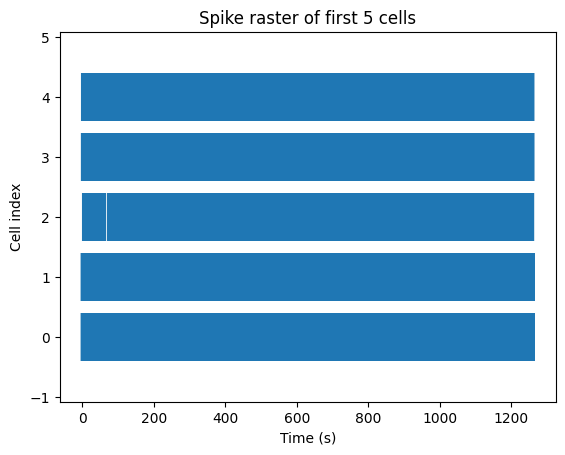

In [3]:
# Check what type of object is in 'spikes'
print("Type of spikes:", type(spikes_dict))
print("Length of spikes list:", len(spikes_dict))
print("First element:", spikes_dict[0])

# Optional: plot the first few spike times
import matplotlib.pyplot as plt

plt.eventplot(spikes_dict[:5], orientation='horizontal', linelengths=0.8)
plt.xlabel("Time (s)")
plt.ylabel("Cell index")
plt.title("Spike raster of first 5 cells")
plt.show()


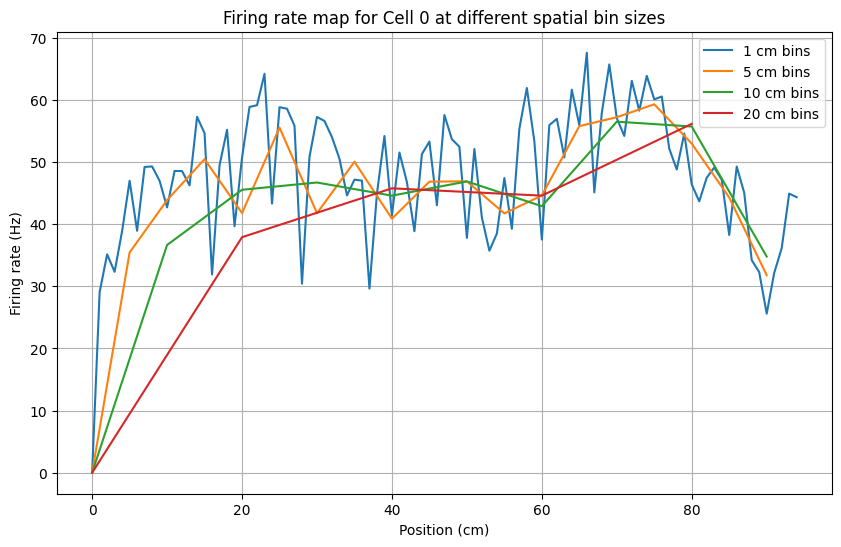

In [4]:
#A
import numpy as np
import matplotlib.pyplot as plt

def compute_firing_rate_map(position, time, spikes, bin_size):
    # Create spatial bins
    space_bins = np.arange(0, np.max(position), bin_size)

    # Compute occupancy (time spent in each bin)
    dt = np.mean(np.diff(time))  # assume uniform sampling
    position_bin_indices = np.digitize(position, space_bins)
    occupancy = np.bincount(position_bin_indices, minlength=len(space_bins)+1) * dt

    # Compute spikes per bin (interpolate spike position from time)
    spike_positions = np.interp(spikes, time, position)  # spike positions along the track
    spike_bin_indices = np.digitize(spike_positions, space_bins)
    spike_counts = np.bincount(spike_bin_indices, minlength=len(space_bins)+1)

    # Avoid divide-by-zero
    with np.errstate(divide='ignore', invalid='ignore'):
        rate_map = np.nan_to_num(spike_counts / occupancy)

    return space_bins, rate_map[:len(space_bins)]

# Use cell 0 (you can change to other indices)
cell_index = 0
spikes = spikes_dict[cell_index]

# Try different bin sizes
bin_sizes = [1, 5, 10, 20]

plt.figure(figsize=(10, 6))
for bin_size in bin_sizes:
    bins, rates = compute_firing_rate_map(x, t, spikes, bin_size)
    plt.plot(bins, rates, label=f'{bin_size} cm bins')

plt.xlabel('Position (cm)')
plt.ylabel('Firing rate (Hz)')
plt.title(f'Firing rate map for Cell {cell_index} at different spatial bin sizes')
plt.legend()
plt.grid(True)
plt.show()


As we decrease the bin size (e.g., from 20 cm to 1 cm), the firing rate map becomes more detailed but also more sensitive to noise, resulting in noisier plots. Larger bins smooth out fluctuations, making the map more robust but potentially obscuring finer spatial structure. This highlights the trade-off between resolution and noise robustness.

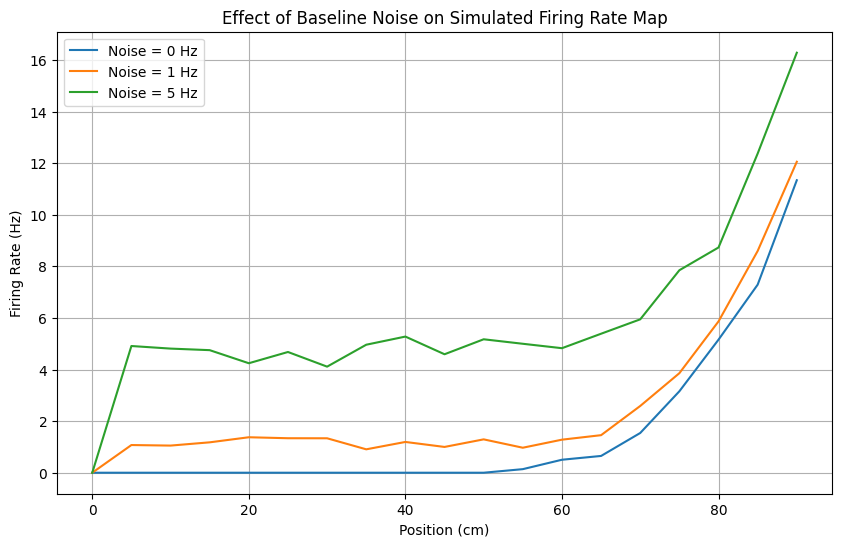

In [5]:
#B
import numpy as np
import matplotlib.pyplot as plt

def simulate_spike_train(position, time, place_center, place_width, peak_rate, baseline_noise):
    dt = np.mean(np.diff(time))  # time step (s)
    firing_rate = peak_rate * np.exp(-0.5 * ((position - place_center) / place_width)**2)
    firing_rate += baseline_noise  # add baseline noise

    # Probability of firing at each time point
    prob_spike = firing_rate * dt
    spikes = np.random.rand(len(time)) < prob_spike

    spike_times = time[spikes]
    return spike_times

def compute_rate_map_from_sim(position, time, spike_times, bin_size):
    space_bins = np.arange(0, np.max(position), bin_size)

    dt = np.mean(np.diff(time))
    pos_bin_idx = np.digitize(position, space_bins)
    occupancy = np.bincount(pos_bin_idx, minlength=len(space_bins)+1) * dt

    spike_positions = np.interp(spike_times, time, position)
    spike_bin_idx = np.digitize(spike_positions, space_bins)
    spike_counts = np.bincount(spike_bin_idx, minlength=len(space_bins)+1)

    with np.errstate(divide='ignore', invalid='ignore'):
        rate_map = np.nan_to_num(spike_counts / occupancy)

    return space_bins, rate_map[:len(space_bins)]

# Use your real position and time
position = x
time = t

# Place field properties
place_center = 100    # cm
place_width = 15      # cm (standard deviation)
peak_rate = 15        # Hz
bin_size = 5          # cm

# Try different noise levels
noise_levels = [0, 1, 5]  # Hz

plt.figure(figsize=(10, 6))
for noise in noise_levels:
    spike_train = simulate_spike_train(position, time, place_center, place_width, peak_rate, noise)
    bins, rate_map = compute_rate_map_from_sim(position, time, spike_train, bin_size)
    plt.plot(bins, rate_map, label=f"Noise = {noise} Hz")

plt.xlabel("Position (cm)")
plt.ylabel("Firing Rate (Hz)")
plt.title("Effect of Baseline Noise on Simulated Firing Rate Map")
plt.legend()
plt.grid(True)
plt.show()


Increasing the baseline noise (i.e., the background firing rate) makes the firing rate map less distinct. With no noise, the place field appears sharp and localized. As noise increases, the map flattens and shows more diffuse activity, making it harder to detect the true place field.

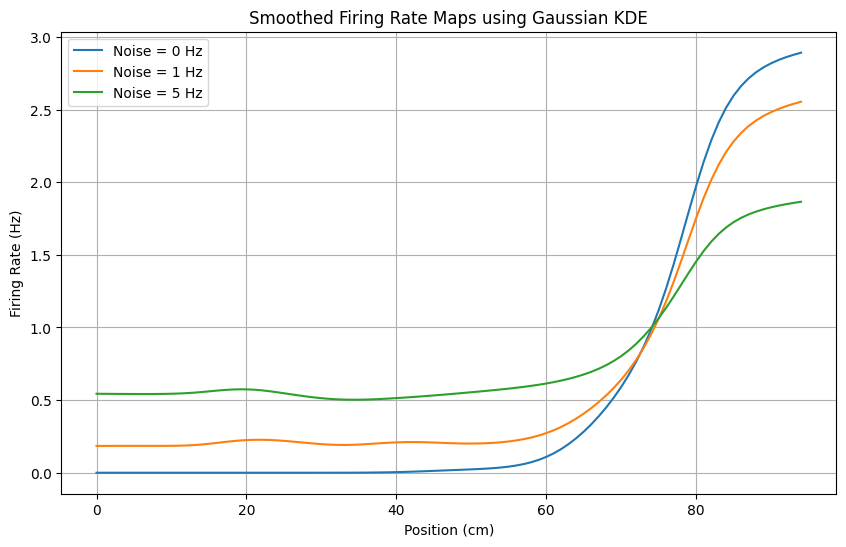

In [6]:
#C
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def smooth_firing_rate(position, time, spike_times, bandwidth=5.0, resolution=1.0):
    # Create fine-grained spatial axis
    pos_axis = np.arange(0, np.max(position), resolution)

    # Interpolate spike positions
    spike_positions = np.interp(spike_times, time, position)

    # Estimate occupancy (use KDE on all positions)
    occupancy_kde = gaussian_kde(position, bw_method=bandwidth / np.std(position))
    occupancy = occupancy_kde(pos_axis)

    # Estimate spike density
    spike_kde = gaussian_kde(spike_positions, bw_method=bandwidth / np.std(spike_positions))
    spike_density = spike_kde(pos_axis)

    # Convert to firing rate (spikes/sec)
    firing_rate = spike_density / occupancy
    firing_rate = np.nan_to_num(firing_rate)

    return pos_axis, firing_rate

# Parameters
place_center = 100     # cm
place_width = 15       # cm
peak_rate = 15         # Hz
noise_levels = [0, 1, 5]  # Hz
bandwidth = 5          # KDE smoothing bandwidth (in cm)

plt.figure(figsize=(10, 6))

for noise in noise_levels:
    spikes_sim = simulate_spike_train(x, t, place_center, place_width, peak_rate, noise)
    pos_axis, rate_smoothed = smooth_firing_rate(x, t, spikes_sim, bandwidth=bandwidth)
    plt.plot(pos_axis, rate_smoothed, label=f'Noise = {noise} Hz')

plt.xlabel("Position (cm)")
plt.ylabel("Firing Rate (Hz)")
plt.title("Smoothed Firing Rate Maps using Gaussian KDE")
plt.legend()
plt.grid(True)
plt.show()


Applying Gaussian kernel smoothing using scipy.stats.gaussian_kde allows for fine spatial resolution (e.g., 1 cm) while suppressing noise. This produces smoother, more interpretable firing rate maps. The choice of bandwidth controls the level of smoothness.

In [7]:
#D
def compute_place_field_properties(spike_times, time, position):
    # Get spike positions
    spike_positions = np.interp(spike_times, time, position)

    # Compute center of mass and width
    if len(spike_positions) == 0:
        return np.nan, np.nan
    center_of_mass = np.mean(spike_positions)
    width = np.std(spike_positions)
    return center_of_mass, width

# Simulate with some noise
noise = 1  # Hz
spikes_sim = simulate_spike_train(x, t, place_center=100, place_width=15, peak_rate=15, baseline_noise=noise)

# Compute
center, width = compute_place_field_properties(spikes_sim, t, x)

print(f"Simulated Place Field:")
print(f"True center:      {100:.2f} cm")
print(f"Estimated center: {center:.2f} cm")
print(f"Estimated width:  {width:.2f} cm")


Simulated Place Field:
True center:      100.00 cm
Estimated center: 81.21 cm
Estimated width:  22.99 cm


## Exercise 2 - mutual information
---
A - Implement the mutual information formula discussed in the lesson, and apply it to the place cell data we simulated.

B - Adapt the simulation so that you can systematically vary 1) Peak firing rate, 2) place cell size 3) baseline noise.
Study how mutual information vary with these parameters. Use both definition of mutual information above, and discuss the differences between them. Make some plots to show how the dependency goes.

In [8]:
def compute_mutual_information(rate_map, occupancy):
    """
    Compute mutual information in bits/spike using Skaggs et al. formula.
    Assumes rate_map and occupancy are arrays of equal length and normalized occupancy.
    """
    rate_map = np.array(rate_map)
    occupancy = np.array(occupancy)

    r_mean = np.sum(rate_map * occupancy)  # average firing rate

    with np.errstate(divide='ignore', invalid='ignore'):
        info = occupancy * (rate_map / r_mean) * np.log2((rate_map + 1e-10) / r_mean)
        info = np.nan_to_num(info)

    return np.sum(info)


In [9]:
def compute_rate_map_and_occupancy(position, time, spike_times, bin_size):
    space_bins = np.arange(0, np.max(position), bin_size)
    dt = np.mean(np.diff(time))

    pos_bin_idx = np.digitize(position, space_bins)
    occupancy_raw = np.bincount(pos_bin_idx, minlength=len(space_bins)+1) * dt
    occupancy = occupancy_raw[:len(space_bins)]
    occupancy_prob = occupancy / np.sum(occupancy)  # Normalize

    spike_positions = np.interp(spike_times, time, position)
    spike_bin_idx = np.digitize(spike_positions, space_bins)
    spike_counts = np.bincount(spike_bin_idx, minlength=len(space_bins)+1)[:len(space_bins)]

    with np.errstate(divide='ignore', invalid='ignore'):
        rate_map = np.nan_to_num(spike_counts / occupancy)

    return space_bins, rate_map, occupancy_prob


In [11]:
param_values = {
    'peak_rate': [5, 10, 20],
    'place_width': [5, 15, 30],
    'baseline_noise': [0, 1, 5]
}

results = {'param': [], 'value': [], 'mutual_info': []}

# Test each parameter independently
for param_name, values in param_values.items():
    for value in values:
        kwargs = {'peak_rate': 15, 'place_width': 15, 'baseline_noise': 1}
        kwargs[param_name] = value

        # Simulate
        spikes_sim = simulate_spike_train(x, t, place_center=100, **kwargs)
        _, rate_map, occ = compute_rate_map_and_occupancy(x, t, spikes_sim, bin_size=5)
        mi = compute_mutual_information(rate_map, occ)

        results['param'].append(param_name)
        results['value'].append(value)
        results['mutual_info'].append(mi)


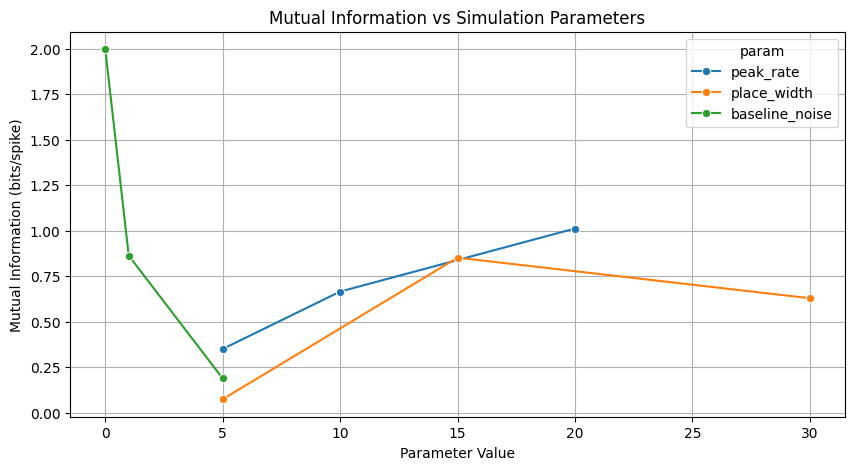

In [12]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(results)
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x="value", y="mutual_info", hue="param", marker="o")
plt.title("Mutual Information vs Simulation Parameters")
plt.ylabel("Mutual Information (bits/spike)")
plt.xlabel("Parameter Value")
plt.grid(True)
plt.show()


Increasing the peak firing rate led to a rise in mutual information, as spikes became more tightly locked to the place field, making each spike more informative. Place field size showed a non-linear relationship: initially, increasing width improved mutual information by generating more spikes, but beyond a certain point, wider fields reduced spatial specificity, lowering the information per spike. Baseline noise had the strongest negative effect — even moderate noise levels drastically reduced mutual information by adding non-specific spikes that obscure the spatial signal.

## Exercise 3 - working with real data
---
Load the data from `linear_track_data.pickle`. It contains neural recordings from a mouse running on a linear track.
- `x` contains the position of the animal
- `t` contains the corresponding times, in seconds
- `spikes` contains a list of lists. Each list contains the timestamps of the spikes emitted by a neuron.

A - Visualiaze the position a s a function of time. Plot the spike of a selected cell in space.

B - Calculate the firing rate maps for all the cells, and plot them sorted by increasing peak positon.

C - Calculate the spatial information for each cell, and plot the distribution. Plot the firing rate maps of the 5 cells with lower spatial information, and the firing rate maps of the 5 cells with higher spatial information. Comment on the differences.

In [13]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
with open('linear_track_data.pickle', 'rb') as f:
    data = pickle.load(f)

x = data['x']             # Position
t = data['t']             # Time
spikes_list = data['spikes']  # List of spike time arrays


<ipython-input-13-91015cdca169>:8: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(f)


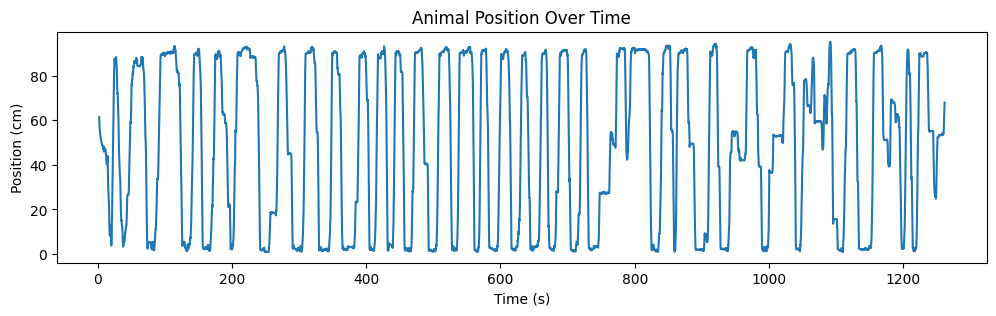

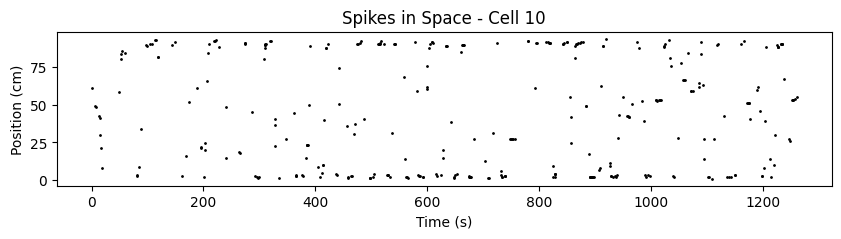

In [14]:
#A
# Plot position as a function of time
plt.figure(figsize=(12, 3))
plt.plot(t, x, label='Position')
plt.xlabel("Time (s)")
plt.ylabel("Position (cm)")
plt.title("Animal Position Over Time")
plt.show()

# Select a cell and plot its spikes in space
cell_idx = 10  # You can change this to try different neurons
spike_times = spikes_list[cell_idx]
spike_pos = np.interp(spike_times, t, x)  # Map spike times to positions

plt.figure(figsize=(10, 2))
plt.plot(spike_times, spike_pos, 'k.', markersize=2)
plt.xlabel("Time (s)")
plt.ylabel("Position (cm)")
plt.title(f"Spikes in Space - Cell {cell_idx}")
plt.show()


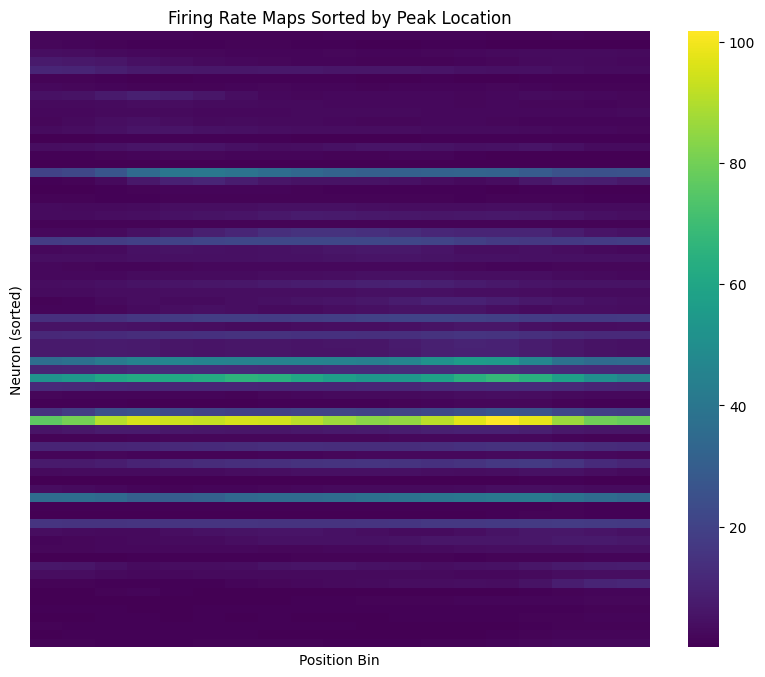

In [15]:
#B
def compute_rate_map_and_occupancy(x, t, spike_times, bin_size=5, track_length=None):
    if track_length is None:
        track_length = np.nanmax(x)
    bins = np.arange(0, track_length + bin_size, bin_size)

    occupancy, _ = np.histogram(x, bins=bins)
    occupancy = occupancy * np.mean(np.diff(t))  # Convert counts to seconds
    occ_smooth = gaussian_filter1d(occupancy, sigma=1)

    spike_pos = np.interp(spike_times, t, x)
    spike_counts, _ = np.histogram(spike_pos, bins=bins)
    spike_counts_smooth = gaussian_filter1d(spike_counts, sigma=1)

    firing_rate = spike_counts_smooth / (occ_smooth + 1e-10)  # Avoid division by 0
    return firing_rate, bins[:-1]

from scipy.ndimage import gaussian_filter1d

rate_maps = []
peak_locs = []

for spikes in spikes_list:
    fr, bin_centers = compute_rate_map_and_occupancy(x, t, spikes)
    rate_maps.append(fr)
    peak_locs.append(np.argmax(fr))

# Sort by peak position
sort_idx = np.argsort(peak_locs)
sorted_maps = np.array(rate_maps)[sort_idx]

# Plot as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_maps, cmap='viridis', xticklabels=False, yticklabels=False)
plt.title("Firing Rate Maps Sorted by Peak Location")
plt.xlabel("Position Bin")
plt.ylabel("Neuron (sorted)")
plt.show()

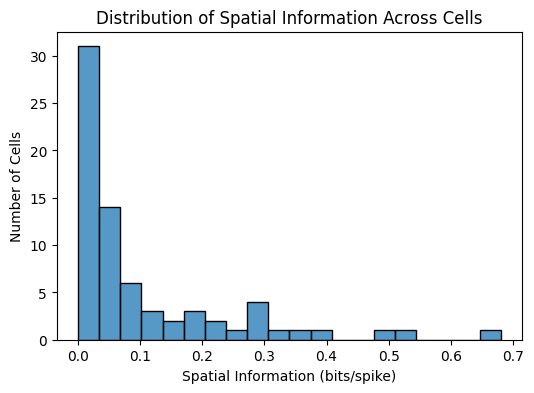

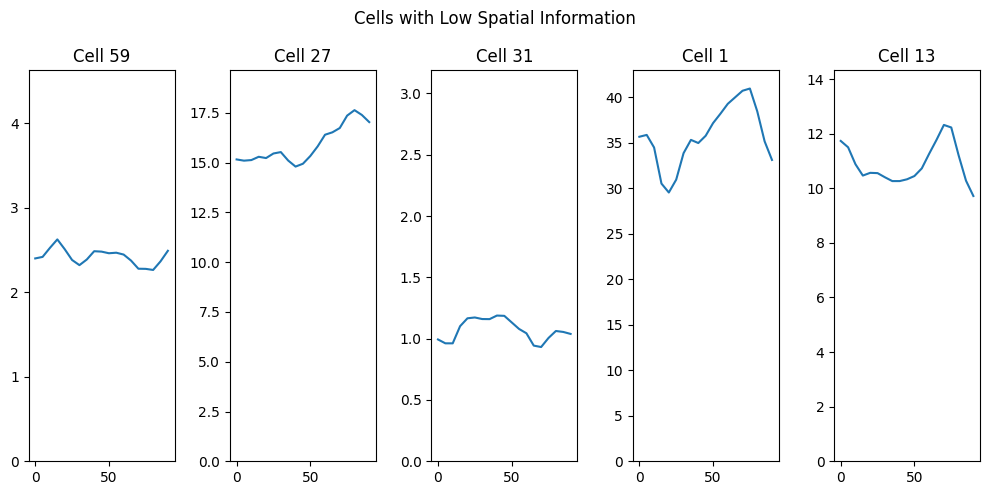

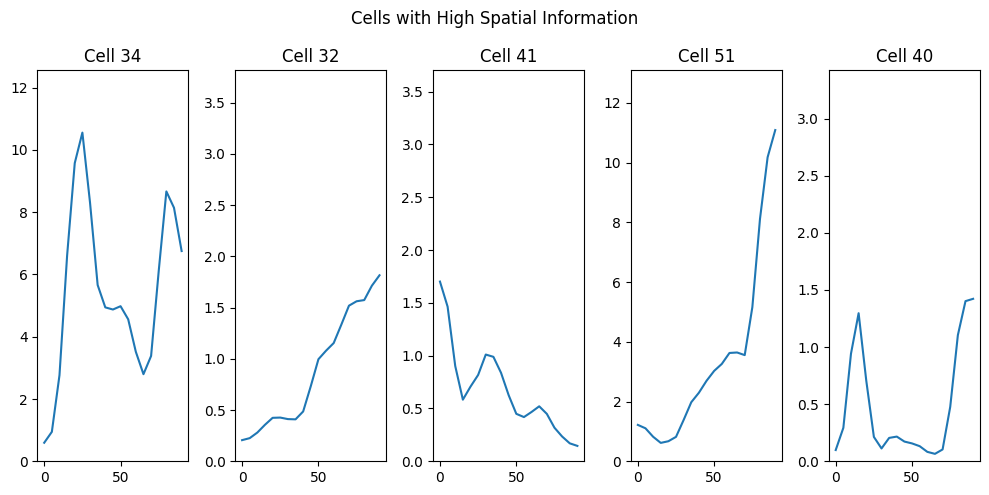

In [16]:
#C
def spatial_information(rate_map, occupancy):
    rate_map = np.array(rate_map)
    occupancy = occupancy / np.sum(occupancy)
    mean_rate = np.sum(rate_map * occupancy)
    with np.errstate(divide='ignore', invalid='ignore'):
        info = np.nansum(
            occupancy * rate_map / (mean_rate + 1e-10) *
            np.log2((rate_map + 1e-10) / (mean_rate + 1e-10))
        )
    return info

# Compute for all cells
infos = []
for i, spikes in enumerate(spikes_list):
    fr, _ = compute_rate_map_and_occupancy(x, t, spikes)
    occ, _ = np.histogram(x, bins=len(fr))
    infos.append(spatial_information(fr, occ))

# Plot distribution
plt.figure(figsize=(6, 4))
sns.histplot(infos, bins=20)
plt.xlabel("Spatial Information (bits/spike)")
plt.ylabel("Number of Cells")
plt.title("Distribution of Spatial Information Across Cells")
plt.show()

# Plot maps for low and high information cells
low_idx = np.argsort(infos)[:5]
high_idx = np.argsort(infos)[-5:]

def plot_rate_maps(indices, title):
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(indices):
        fr, bin_centers = compute_rate_map_and_occupancy(x, t, spikes_list[idx])
        plt.subplot(1, 5, i + 1)
        plt.plot(bin_centers, fr)
        plt.title(f"Cell {idx}")
        plt.ylim(0, np.max(fr) + 2)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_rate_maps(low_idx, "Cells with Low Spatial Information")
plot_rate_maps(high_idx, "Cells with High Spatial Information")


Low-information cells tend to have flat or noisy rate maps, indicating weak or no spatial selectivity. In contrast, high-information cells exhibit sharply peaked and localized firing patterns, characteristic of classic place cells.